<a href="https://colab.research.google.com/github/bartolomeoadrian/computer-vision/blob/main/exam_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar librerías

In [5]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm

!pip -q install ultralytics

from ultralytics import YOLO

model = YOLO('yolo11m.pt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Video original

In [6]:
video_url = 'https://raw.githubusercontent.com/bartolomeoadrian/computer-vision/refs/heads/main/assets/videos/journey.mp4'
r = requests.get(video_url)

with open("/content/journey.mp4", "wb") as f:
    f.write(r.content)

# Función auxiliar para dibujar imagenes

In [7]:
def show_images(images, rows=1, cols=2, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    for i, (title, img) in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray" if img.ndim==2 else None)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Imagen para realizar pruebas

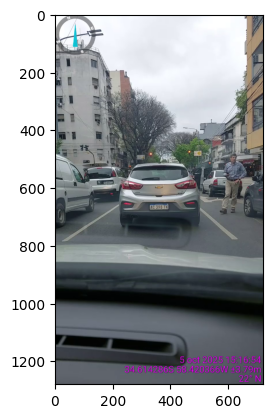

In [11]:
cap = cv2.VideoCapture('/content/journey.mp4')

cap.set(cv2.CAP_PROP_POS_MSEC, 30 * 1000)

ret, frame = cap.read()
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

if ret:
    plt.imshow(frame_rgb)
    plt.show()
else:
    print("No se pudo leer el frame.")

# Función para detectar personas, bicicletas, autos, motos, colectivos, trenes, camiones y luces de tránsito

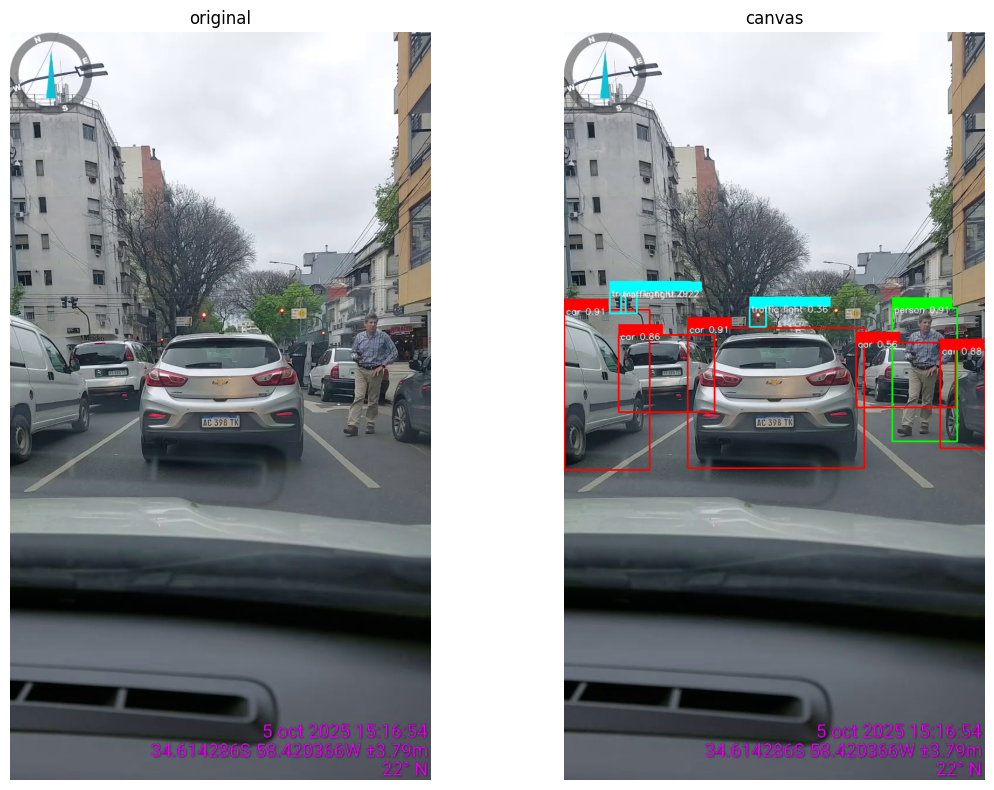

In [24]:
COLORS = {
    0: (0, 255, 0),     # person - verde
    1: (0, 200, 255),   # bicycle - naranja
    2: (255, 0, 0),     # car - azul
    3: (0, 128, 255),   # motorcycle - naranja fuerte
    5: (255, 255, 0),   # bus - celeste
    6: (255, 0, 255),   # train - magenta
    7: (180, 0, 180),   # truck - violeta
    9: (0, 255, 255),   # traffic light - amarillo
}

def detect_objects_full(frame_rgb, canvas, model,
                        conf=0.03, iou=0.30, imgsz=960,
                        margin=8, thickness=2, min_score=0.20):
    h, w = frame_rgb.shape[:2]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    names = getattr(model, 'names', None) or getattr(getattr(model, 'model', None), 'names', None) or {}

    target_classes = [0, 1, 2, 3, 5, 6, 7, 9]
    det = model(frame_rgb, imgsz=imgsz, conf=conf, iou=iou,
                classes=target_classes, verbose=False, device=device, max_det=300)[0]

    if len(det.boxes):
        for box in det.boxes:
            score = float(box.conf[0])
            if score < min_score:
                continue

            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls = int(box.cls[0])

            # margen y límites
            x1 = max(0, x1 - margin); y1 = max(0, y1 - margin)
            x2 = min(w, x2 + margin); y2 = min(h, y2 + margin)

            color = COLORS.get(cls, (120, 40, 140))

            # bbox
            cv2.rectangle(canvas, (x1, y1), (x2, y2), color, thickness)

            # label
            cls_name = (names[cls] if isinstance(names, dict) and cls in names
                        else (names[cls] if isinstance(names, (list, tuple)) and 0 <= cls < len(names)
                              else str(cls)))
            label = f"{cls_name} {score:.2f}"

            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, max(1, thickness-1))
            y1_text = max(0, y1 - th - 6)
            cv2.rectangle(canvas, (x1, y1_text), (x1 + tw + 6, y1_text + th + 4), color, -1)
            cv2.putText(canvas, label, (x1 + 3, y1 + th - 4),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), max(1, thickness-1), cv2.LINE_AA)


canvas = frame_rgb.copy()
detect_objects_full(frame_rgb, canvas, model)

show_images([
    ("original", frame_rgb),
    ("canvas", canvas)
], rows=1, cols=2)

# Generar video

In [20]:
cap = cv2.VideoCapture('/content/journey.mp4')

model = YOLO('yolo11m.pt')

fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out = cv2.VideoWriter('/content/journey_final.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

with tqdm(total=total_frames, desc='Processing video') as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb_final_video = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        canvas = frame_rgb_final_video.copy()
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

        detect_objects_full(frame_rgb_final_video, canvas, model)

        out.write(canvas)
        pbar.update(1)

cap.release()
out.release()

Processing video: 100%|██████████| 1813/1813 [42:34<00:00,  1.41s/it]


# Resultado

[Ver acá](https://raw.githubusercontent.com/bartolomeoadrian/computer-vision/refs/heads/main/assets/videos/journey_final.mp4)